# Vehicle Detection Project

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

from skimage.feature import hog
from sklearn.preprocessing import Imputer
from scipy.ndimage.measurements import label

import DataProcessing.preprocess as proc
from DataProcessing.preprocess import Extract
import DataProcessing.scan as scan
import DataProcessing.pipeline as ppl

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import imp
import time
import glob
import pickle
import os

In [2]:
%matplotlib inline

## Histogram of Oriented Gradients (HOG)

### Loading Files

In [3]:
car_files = glob.glob('data/vehicles/*/*.png')
noncar_files = glob.glob('data/non-vehicles/*/*.png')

In [4]:
X = [] 

for file in car_files + noncar_files:
    X.append(cv2.imread(file))

X = np.array(X)
y = np.hstack((np.ones(len(car_files)), np.zeros(len(noncar_files))))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Dump the labeled data set into a pickle file. `data.p` is needed by the `DataProcessing/pipeline.py`.

In [66]:
pickle.dump({'X': X, 'y': y}, open('data.p', 'wb'))

### Search for Parameters with Cross-Validation

I started by searching parameters with randomized search, below is the set of parameters I considered:

In [25]:
param_grid = {'ext__color_space': ['HLS', 'YUV', 'YCrCb'], 'ext__spatial_size': [(24, 24), (32, 32), (40, 40)],
              'ext__hist_bins': [16, 32, 48], 'ext__orient': [6, 9, 12], 'ext__pix_per_cell': [6, 8, 10], 
              'ext__hog_channel': [0, 1, 2, 'ALL'], 'ext__cell_per_block': [2, 3],
              'svc__C': np.logspace(-4, 4, 9)}

As can be seen from the `param_grid`, the `color_space`, `spatial_size`, `hist_bins`, `orient`, `pix_per_cell` and `hog_channel` are all considered as the hyper-parameters of the pipeline. Here we don't search over `cell_per_block` and its default value is 2.  These hyperparamters are paramters fed into an instance of the `Extract` class I created in `DataProcessing/preprocess.py`. 

The `C` hyperparamter which regularizes the margin between misclassified instances and classification boundary is also searched.  

The critieria I used is `roc_auc`. It means [the expected proportion of positives ranked before a uniformly drawn random negative](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it). 
I searched with three-fold cross validation and 30 set of parameters were uniformly drawn from the `param_grid`.

In [26]:
pipeline = Pipeline([('ext', Extract()), ('imp', Imputer()), ('scl', StandardScaler()), ('svc', LinearSVC())])

rnd_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, cv=3)
rnd_search.fit(X_train, y_train);

Below is the result of `rnd_search.best_params`:
```python
{'ext__cell_per_block': 2,
 'ext__color_space': 'YUV',
 'ext__hist_bins': 48,
 'ext__hog_channel': 'ALL',
 'ext__orient': 9,
 'ext__pix_per_cell': 8,
 'ext__spatial_size': (24, 24),
 'svc__C': 100.0}
```

Moving forward, I will use the following parameters:
 `color_space='YUV'`, `spatial_size=(24, 24)`, `hist_bins=48`, HOG parameters: `orient=9`, `pix_per_cell=8`, `cell_per_block=2`, and `hog_channel='ALL'` and `C=100` for the linear SVM classifier.

## Sliding Window Search

Below I perform sliding window over `test1.jpg`. 

In [148]:
yuv, yuv_boxes = scan.find_cars(cv2.imread('test_images/test1.jpg'), X, y, color='YUV', C=100)

Below is the result of detected blocks (in blue) from `test1.jpg`.

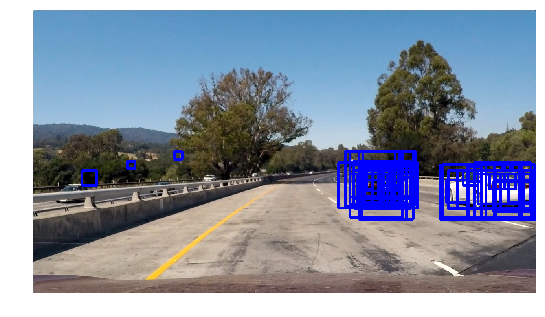

In [58]:
plt.rcParams['figure.figsize'] = (9, 6)
plt.imshow(cv2.cvtColor(yuv, cv2.COLOR_BGR2RGB));
plt.axis('off');

In [6]:
test_img_list = glob.glob('test_images/*.jpg')

In [254]:
imp.reload(ppl)
imp.reload(scan)

<module 'DataProcessing.scan' from '/home/jychang/Documents/self_learn/udacity_sdnd/CarND-Vehicle-Detection/DataProcessing/scan.py'>

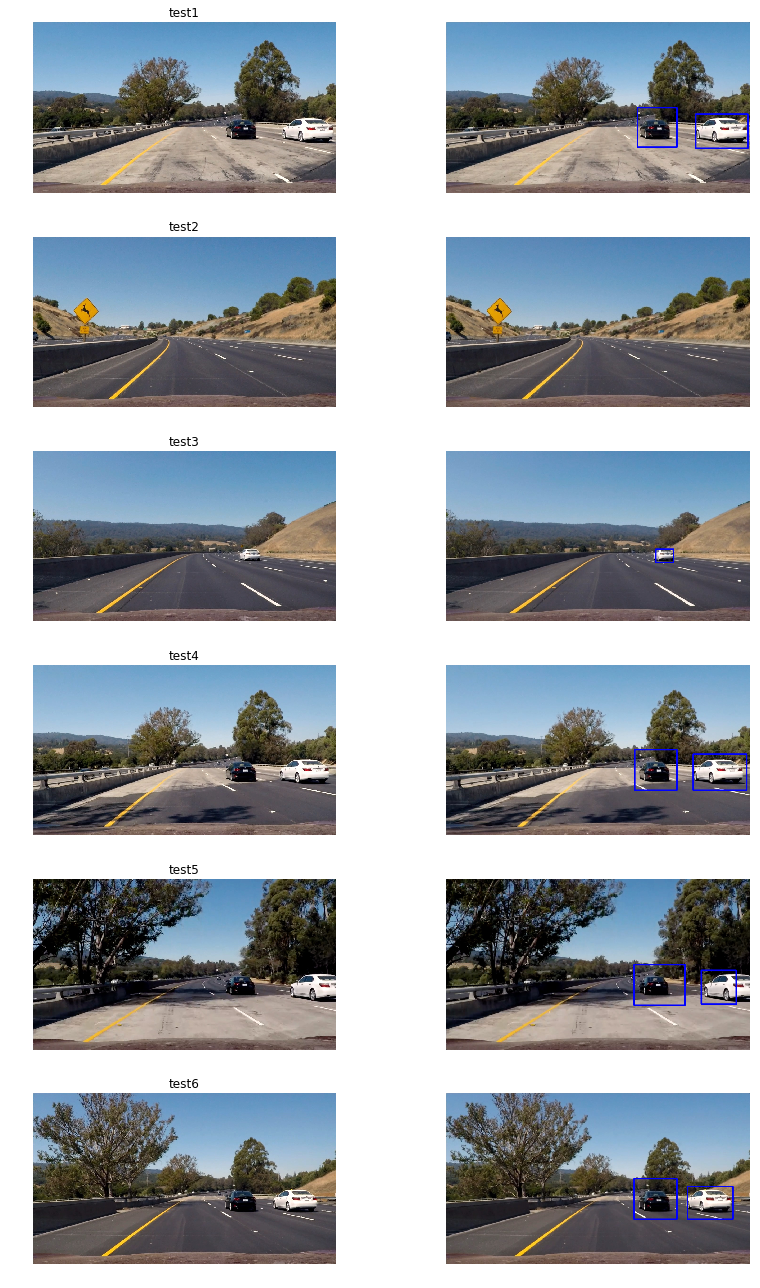

In [255]:
fig, ax = plt.subplots(6, 2, figsize=(12, 18))

for i, img_fp in enumerate(sorted(test_img_list)):
    if hasattr(ppl.pipeline, 'hist'):
        del ppl.pipeline.hist
    img = mpimg.imread(img_fp)
    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][0].set_title(img_fp.split('/')[-1].split('.')[0])
    ax[i][1].imshow(ppl.pipeline(img))
    ax[i][1].axis('off')
plt.tight_layout()

## Video Implementation


### Test Video

In [260]:
if hasattr(ppl.pipeline, 'hist'):
    del ppl.pipeline.hist

In [261]:
test_video = 'output_videos/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
#if hasattr(pipeline, 'img_size'):
#    del pipeline.img_size
clip1_out = clip1.fl_image(ppl.pipeline) #NOTE: this function expects color images!!
%time clip1_out.write_videofile(test_video, audio=False)

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4



 97%|█████████▋| 38/39 [03:50<00:06,  6.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 4min 47s, sys: 476 ms, total: 4min 48s
Wall time: 3min 50s


In [262]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video))

### Project Video

In [263]:
if hasattr(ppl.pipeline, 'hist'):
    del ppl.pipeline.hist

In [264]:
project_video = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("project_video.mp4")
#if hasattr(pipeline, 'img_size'):
#    del pipeline.img_size
clip2_out = clip2.fl_image(ppl.pipeline) #NOTE: this function expects color images!!
%time clip2_out.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



 12%|█▏        | 147/1261 [13:31<1:54:58,  6.19s/it]


 23%|██▎       | 293/1261 [25:38<1:18:17,  4.85s/it]


 35%|███▍      | 439/1261 [37:30<1:05:44,  4.80s/it]


 47%|████▋     | 587/1261 [49:17<53:25,  4.76s/it]


 59%|█████▊    | 738/1261 [1:01:15<41:11,  4.73s/it]


 70%|███████   | 884/1261 [1:12:46<29:58,  4.77s/it]


 82%|████████▏ | 1029/1261 [1:24:16<18:31,  4.79s/it]


 93%|█████████▎| 1172/1261 [1:35:39<06:59,  4.71s/it]


100%|█████████▉| 1260/1261 [1:42:38<00:04,  4.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 2h 9min 28s, sys: 8.86 s, total: 2h 9min 37s
Wall time: 1h 42min 38s


In [265]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))

### Procedure Rejecting False Postives

In [232]:
yuv_heatmap =  ppl.add_heat(np.zeros_like(yuv[:,:,0]), yuv_boxes)

In [246]:
thresholded = ppl.apply_threshold(yuv_heatmap, 2)

In [247]:
labels = label(thresholded)

In [248]:
result = ppl.draw_labeled_bboxes(mpimg.imread('test_images/test1.jpg'), labels)

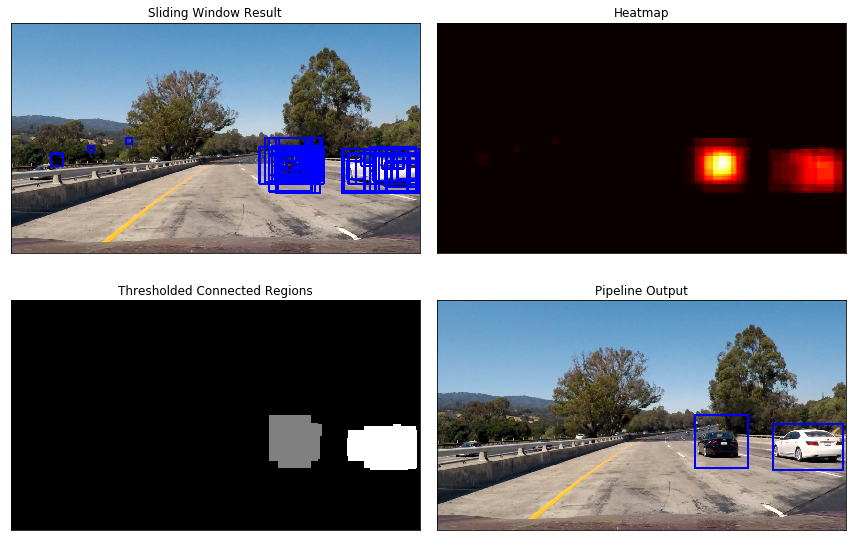

In [249]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax[0][0].imshow(cv2.cvtColor(yuv, cv2.COLOR_BGR2RGB))
ax[0][0].set_title('Sliding Window Result')
ax[0][1].imshow(yuv_heatmap, cmap='hot')
ax[0][1].set_title('Heatmap')
ax[1][0].imshow(labels[0], cmap='gray')
ax[1][0].set_title('Thresholded Connected Regions')
ax[1][1].imshow(result);
ax[1][1].set_title('Pipeline Output');
plt.tight_layout();